# 2.0 - Permutation test figure

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### TCGA interactions

In [5]:
TCGA_PROJECT = "HNSC"
GENES = pd.read_csv("../data/L1000.txt", header=None)
N_GENES = len(GENES)
N_INTERACTIONS = int((N_GENES * (N_GENES-1))/2)

use_columns = ["interaction", 'rmst_diff_f1+f2', 'rmst_diff_f1-f2', 'rmst_diff_f1*f2']

tcga_interactions = pd.read_csv(f"../computed_interactions/{TCGA_PROJECT}.csv", index_col=[0], usecols=use_columns)
tcga_interactions = tcga_interactions.fillna(-1).sort_values(by=["rmst_diff_f1-f2"])

### TCGA permutation test results

In [6]:
tcga_permutations = [
    pd.read_csv(f"../computed_permutations/{TCGA_PROJECT}/{fn}", index_col=[0], usecols=use_columns)
    for fn in tqdm(os.listdir(f"../computed_permutations/{TCGA_PROJECT}/"))
]

100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


### Interaction values

In [7]:
def get_interaction_values(df, interaction_column, N_INTERACTIONS=N_INTERACTIONS, placeholder=-1):
    values = df[interaction_column].dropna().values
    return np.append(values, [placeholder]*(N_INTERACTIONS - len(values)))

In [8]:
PLACEHOLDER = -1

tcga_interation_values_additive = get_interaction_values(tcga_interactions, "rmst_diff_f1+f2", N_INTERACTIONS, PLACEHOLDER)
tcga_interation_values_competitive = get_interaction_values(tcga_interactions, "rmst_diff_f1-f2", N_INTERACTIONS, PLACEHOLDER)

tcga_permutation_values = [
    get_interaction_values(tcga_permutations[i], "rmst_diff_f1+f2", N_INTERACTIONS, PLACEHOLDER)
    for i in range(len(tcga_permutations))
]
tcga_permutation_values_additive = np.concatenate(tcga_permutation_values)

tcga_permutation_values = [
    get_interaction_values(tcga_permutations[i], "rmst_diff_f1-f2", N_INTERACTIONS, PLACEHOLDER)
    for i in range(len(tcga_permutations))
]
tcga_permutation_values_competitive = np.concatenate(tcga_permutation_values)

In [9]:
BINS = 100

def plot_interaction_distribution(tcga_interation_values, tcga_permutation_values, ax, sub_axes, PERMUTATION_LIMIT, BINS, TCGA_PROJECT, INTERACTION_COLUMN, interaction_color="red"):
    top_limit = np.sum(tcga_permutation_values > 0)/len(tcga_permutation_values) / np.sqrt(BINS)
    top_limit_zoom = np.sum(tcga_permutation_values > np.percentile(tcga_permutation_values, PERMUTATION_LIMIT))/len(tcga_permutation_values) / 2

    # f, ax = plt.subplots(1,1, figsize=(8,4))

    ax.hist(tcga_interation_values, bins=BINS, color=interaction_color, zorder=5, density=True, alpha=0.5, label=f"{INTERACTION_COLUMN} interaction")
    ax.hist(tcga_permutation_values, bins=BINS, color="gray", zorder=3, density=True, alpha=0.7, label="permutations")

    ax.set_ylim(top=top_limit)
    ax.set_xlim(0)

    ## zoomin
    low_threshold = np.percentile(tcga_permutation_values, PERMUTATION_LIMIT)

    zoom_int_values = tcga_interation_values[tcga_interation_values > low_threshold]
    zoom_per_values = tcga_permutation_values[tcga_permutation_values > low_threshold]

    max_value = max((zoom_int_values.max(), zoom_per_values.max())) +1

    #sub_axes = f.add_axes([0.45, 0.43, 0.4, 0.4])  # Creating a new axes for the zoomed-in plot
    sub_axes.hist(tcga_interation_values, bins=BINS, color=interaction_color, zorder=5, density=True, alpha=0.5, label=f"$n$ = {len(zoom_int_values)}", range=(-2, max_value))
    sub_axes.hist(tcga_permutation_values, bins=BINS, color="gray", zorder=3, density=True, alpha=0.7, label=r'$\overline{n}$'+f" = {len(zoom_per_values)/len(tcga_permutations):.1f}", range=(-2, max_value))

    print(len(zoom_per_values)/len(tcga_permutations))

    sub_axes.set_ylim(0, top_limit_zoom)
    sub_axes.set_xlim([np.percentile(tcga_permutation_values, PERMUTATION_LIMIT), max_value +1])

    for a in [ax, sub_axes]:
        for loc in ["top", "right"]:
            a.spines[loc].set_visible(False)
        a.set_yticks([])
        
    sub_axes.legend(fontsize=12, frameon=False, title="Num. of hits", title_fontsize=13)
    ax.legend(fontsize=12, frameon=False, loc=2)

    for a in [ax, sub_axes]:
        a.set_xlabel("RMST difference", fontsize=13)
        a.set_ylabel("density", fontsize=14)


    # ax.set_title(f"TCGA-{TCGA_PROJECT} ({INTERACTION_COLUMN})", fontsize=14)

55.92
55.92


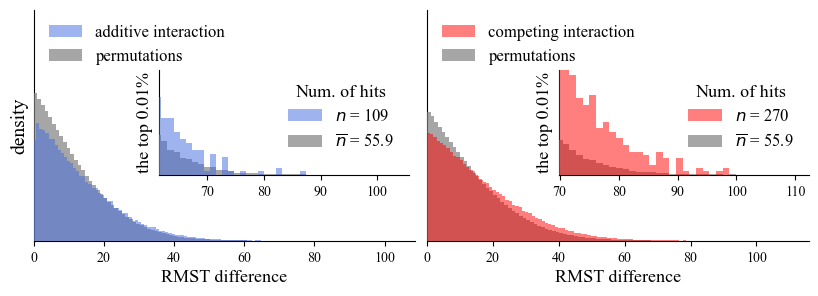

In [11]:
PERMUTATION_LIMIT = 99.99
BINS = 100

plt.rcParams["font.family"] = "Times New Roman"

f, ax = plt.subplots(1,2, figsize=(10,3), gridspec_kw={"wspace": 0.03})

sub_height = 0.35
sub_width = 0.25
sub_ax0 = f.add_axes([0.25, 0.33, sub_width, sub_height])
sub_ax1 = f.add_axes([0.65, 0.33, sub_width, sub_height])


plot_interaction_distribution(
    tcga_interation_values=tcga_interation_values_additive,
    tcga_permutation_values=tcga_permutation_values_additive,
    ax=ax[0], sub_axes=sub_ax0,
    PERMUTATION_LIMIT=PERMUTATION_LIMIT,
    BINS=BINS,
    TCGA_PROJECT=TCGA_PROJECT, INTERACTION_COLUMN="additive",
    interaction_color="royalblue"
)

plot_interaction_distribution(
    tcga_interation_values=tcga_interation_values_competitive,
    tcga_permutation_values=tcga_permutation_values_competitive,
    ax=ax[1], sub_axes=sub_ax1,
    PERMUTATION_LIMIT=PERMUTATION_LIMIT,
    BINS=BINS,
    TCGA_PROJECT=TCGA_PROJECT, INTERACTION_COLUMN="competing",
    interaction_color="red"
)

ax[1].set_ylabel(None)
for subax in [sub_ax0, sub_ax1]:
    subax.set_ylabel(f"the top {100-PERMUTATION_LIMIT:.2f}%", fontsize=13)
    subax.set_xlabel(None)

f.savefig("../figures/figure5_permutation_test_additive-competing.pdf", dpi=500, bbox_inches="tight")

In [ ]:
tcga_permutations

[              rmst_diff_f1+f2  rmst_diff_f1-f2  rmst_diff_f1*f2
 interaction                                                    
 AARS*ABCB6                NaN        21.656958        16.364538
 AARS*ABHD4                NaN              NaN        16.023324
 AARS*ABHD6                NaN         1.743936              NaN
 AARS*ACAA1                NaN              NaN        12.157336
 AARS*ACAT2                NaN        13.850049         1.917495
 ...                       ...              ...              ...
 ZNF451*ZRSR2         8.260904              NaN        16.280015
 ZNF451*ZW10               NaN        24.586847         5.304403
 ZNHIT3*ZRSR2              NaN              NaN        29.298327
 ZNHIT3*ZW10         28.554299              NaN              NaN
 ZRSR2*ZW10          13.501075              NaN        12.202768
 
 [290531 rows x 3 columns],
                rmst_diff_f1+f2  rmst_diff_f1-f2  rmst_diff_f1*f2
 interaction                                               